# Transfer Learning on Hagrid Dataset

## Setup

In [19]:
# set the python env so that we can use the project utils
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
from tqdm import tqdm

K.clear_session()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set (15% of total)


In [20]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("../../sign_datasets/hagrid-classification-512p-10-percent/call/0a67f153-2168-4abe-871a-d07eb3d93e39.jpeg")

print(f'Image dimentions: {img.size}')

Image dimentions: (512, 512)


In [25]:
dataset_path = "../../sign_datasets/hagrid-classification-512p-10-percent/"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=64,
    shuffle=True,
    seed=42,
)

train_size = int(len(dataset) * 0.7)

train_dataset = dataset.take(train_size)
temp_dataset = dataset.skip(train_size)
val_dataset = temp_dataset.take(int(0.5 * len(temp_dataset)))
test_dataset = temp_dataset.skip(int(0.5 * len(temp_dataset)))

def normalize_image(image, label):
    precomputed_mean = [0.5810514688491821, 0.5178735852241516, 0.48736947774887085]
    precomputed_std = [0.6329583525657654, 0.5746501684188843, 0.5465894937515259]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std

    return image, label

del temp_dataset

buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)

train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(f'Train batches: {len(train_dataset)}')
print(f'Validation batches: {len(val_dataset)}')
print(f'Test batches: {len(test_dataset)}')

Found 50698 files belonging to 18 classes.
Train batches: 555
Validation batches: 119
Test batches: 119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68311566..0.71660703].


(4, 224, 224, 3)


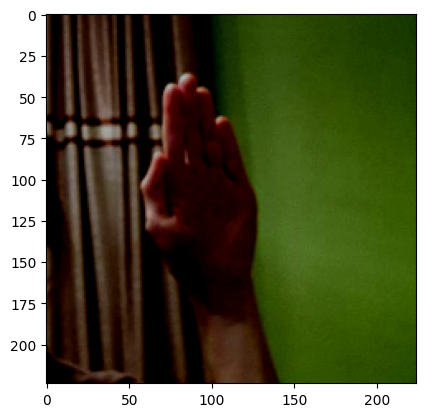

In [22]:
# Print a random image to make sure it's properly shown
images, labels = next(iter(train_dataset))

print(images.shape)

plt.imshow(images[0, :, :, :])
plt.show()

## Helper Methods

The following methods aim to make the code easier

In [6]:
from sklearn.metrics import confusion_matrix


def get_class_count(dataset):
    """Find out how many elements bellong to each class
    This method is used in plot_class_distribution to plot
    the distribution of the data
    
    Return:
        class_counts: A dictionary with the class name as a key
        and the total items as a value
    """
    class_counts = {}
    for images, labels in tqdm(dataset):
        for label in labels:
            # Here the label is a tensor with 1 element
            # We have to convert it to numpy
            label = label.numpy()
            # Count it
            class_counts[label] = class_counts.get(label, 0) + 1
    # Return the counts
    return class_counts

def plot_class_distribution(dataset, title: str):
    """Get how many elements belong to each class and plot them
    
    This method can help us see if there is an inbalance in the data
    """
    # Get the class counts
    class_counts = get_class_count(dataset)

    # greate an index for the dataframe
    index = list(range(len(class_counts)))
    # Create a dataframe
    df = pd.DataFrame(class_counts, index=index)
    
    # Set the figure size
    plt.figure(figsize=(12, 6))
    # Add the data
    ax = sns.barplot(df)
    # Set the title
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot the history returned by the training
    """

    # Convert history to a DataFrame
    history_df = pd.DataFrame(history.history)

    # Create a single figure with two subplots
    fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plotting training and validation loss
    sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax1[0])
    ax1[0].set_title('Model Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].legend(['Train', 'Validation'])
    
    # Plotting training and validation accuracy
    sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax1[1])
    ax1[1].set_title('Model Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].legend(['Train', 'Validation'])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 555/555 [00:50<00:00, 10.92it/s]


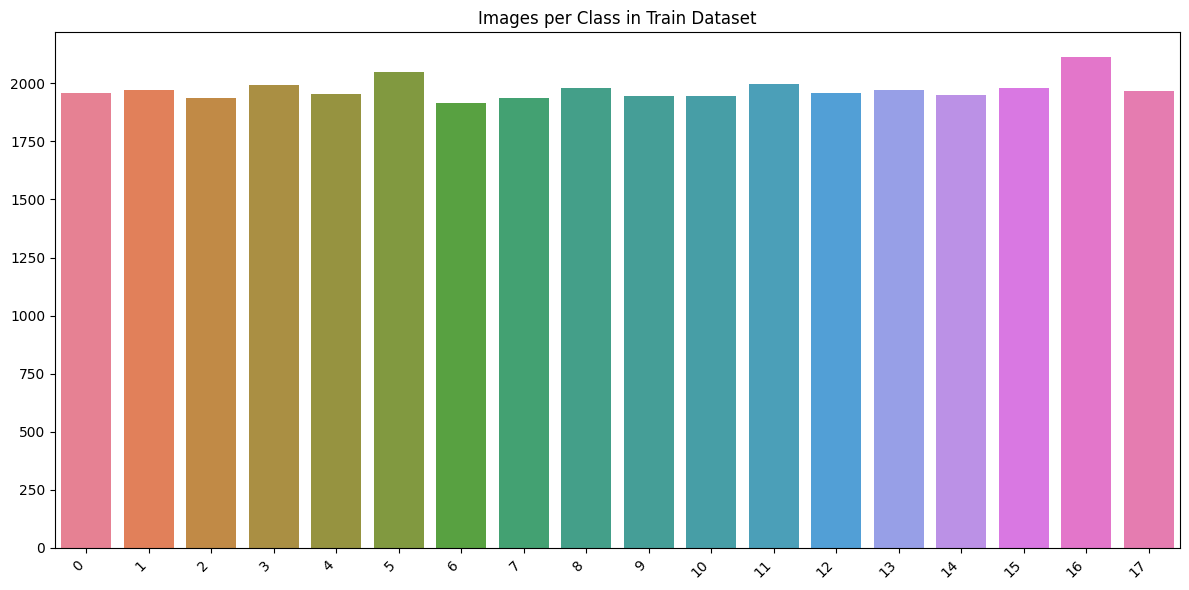

In [7]:
plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 119/119 [00:29<00:00,  4.01it/s]


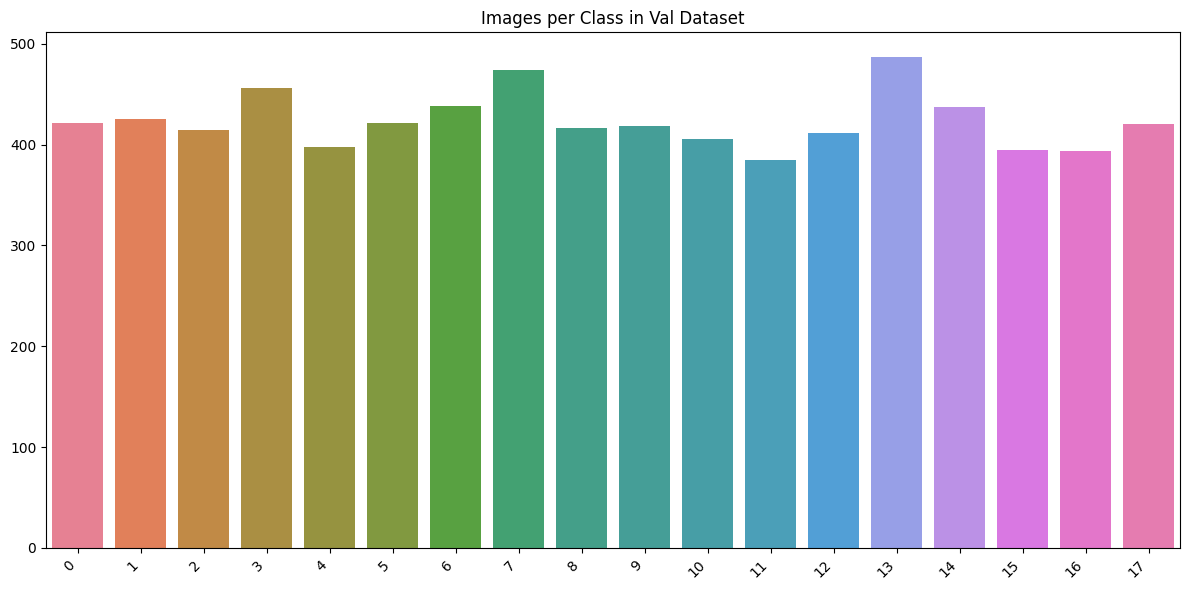

In [8]:
plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 119/119 [00:33<00:00,  3.58it/s]


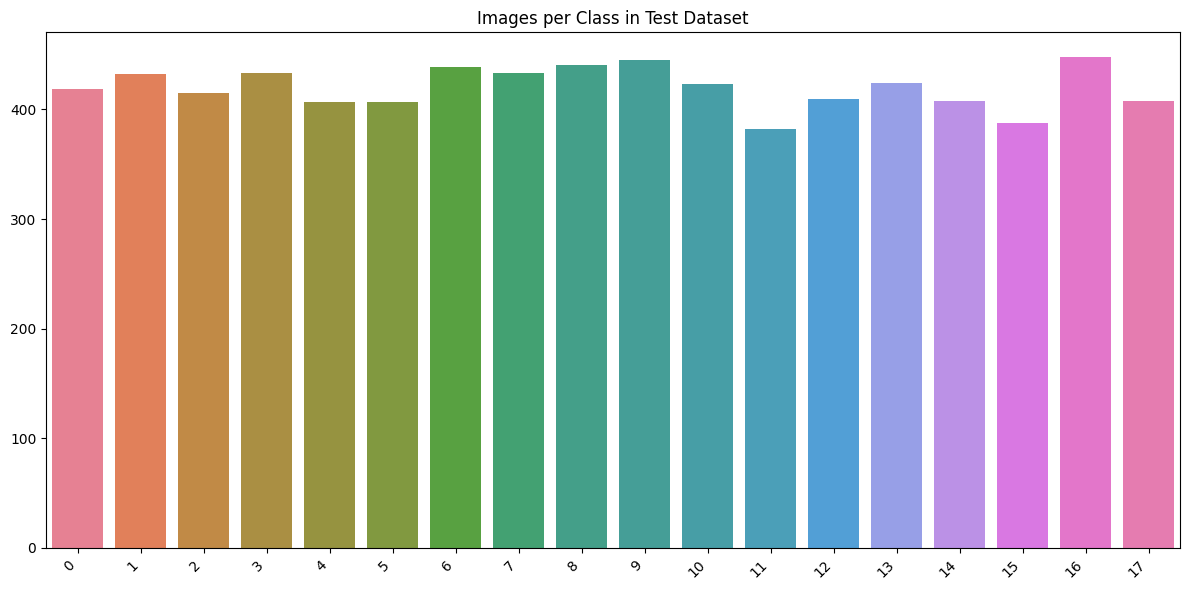

In [9]:
plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## Extract Class Names

In [11]:
def get_class_names(test_dataset, verbose: bool = False):
    class_names = set()

    for _, labels in tqdm(test_dataset, desc="Gathering Labels"):
        for label in labels:
            class_names.add(int(label))

    if verbose:
        print(f"Unique Dataset Labels: {class_names}")

    return class_names

In [12]:
class_names = get_class_names(test_dataset=test_dataset, verbose=True)

Gathering Labels: 100%|██████████| 119/119 [00:41<00:00,  2.84it/s]

Unique Dataset Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}


## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (400, 400) to (224, 244)

We will try __different hidden sizes__ with __3 epochs__, using a __dropout__ of 0.3

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,786 (9.25 MB)

 Trainable params: 166,546 (650.57 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None
Epoch 1/10


I0000 00:00:1738501931.033195   23459 service.cc:148] XLA service 0x7f05700139c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738501931.057585   23459 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-02-02 15:12:11.595425: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738501932.776660   23459 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/555 ━━━━━━━━━━━━━━━━━━━━ 3:54:17 25s/step - accuracy: 0.0469 - loss: 3.3545

I0000 00:00:1738501948.613924   23459 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


555/555 ━━━━━━━━━━━━━━━━━━━━ 157s 237ms/step - accuracy: 0.3980 - loss: 1.9474 - val_accuracy: 0.6107 - val_loss: 1.1763
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 183s 234ms/step - accuracy: 0.6110 - loss: 1.1731 - val_accuracy: 0.6393 - val_loss: 1.0797
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 111s 200ms/step - accuracy: 0.6440 - loss: 1.0704 - val_accuracy: 0.6531 - val_loss: 1.0360
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 110s 198ms/step - accuracy: 0.6694 - loss: 0.9967 - val_accuracy: 0.6601 - val_loss: 1.0257
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 108s 195ms/step - accuracy: 0.6846 - loss: 0.9397 - val_accuracy: 0.6637 - val_loss: 1.0057
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 109s 196ms/step - accuracy: 0.6991 - loss: 0.8972 - val_accuracy: 0.6622 - val_loss: 1.0150
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 108s 195ms/step - accuracy: 0.7051 - loss: 0.8641 - val_accuracy: 0.6658 - val_loss: 0.9964
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 106s 191ms/step - accuracy: 0.7197 - loss: 0.82

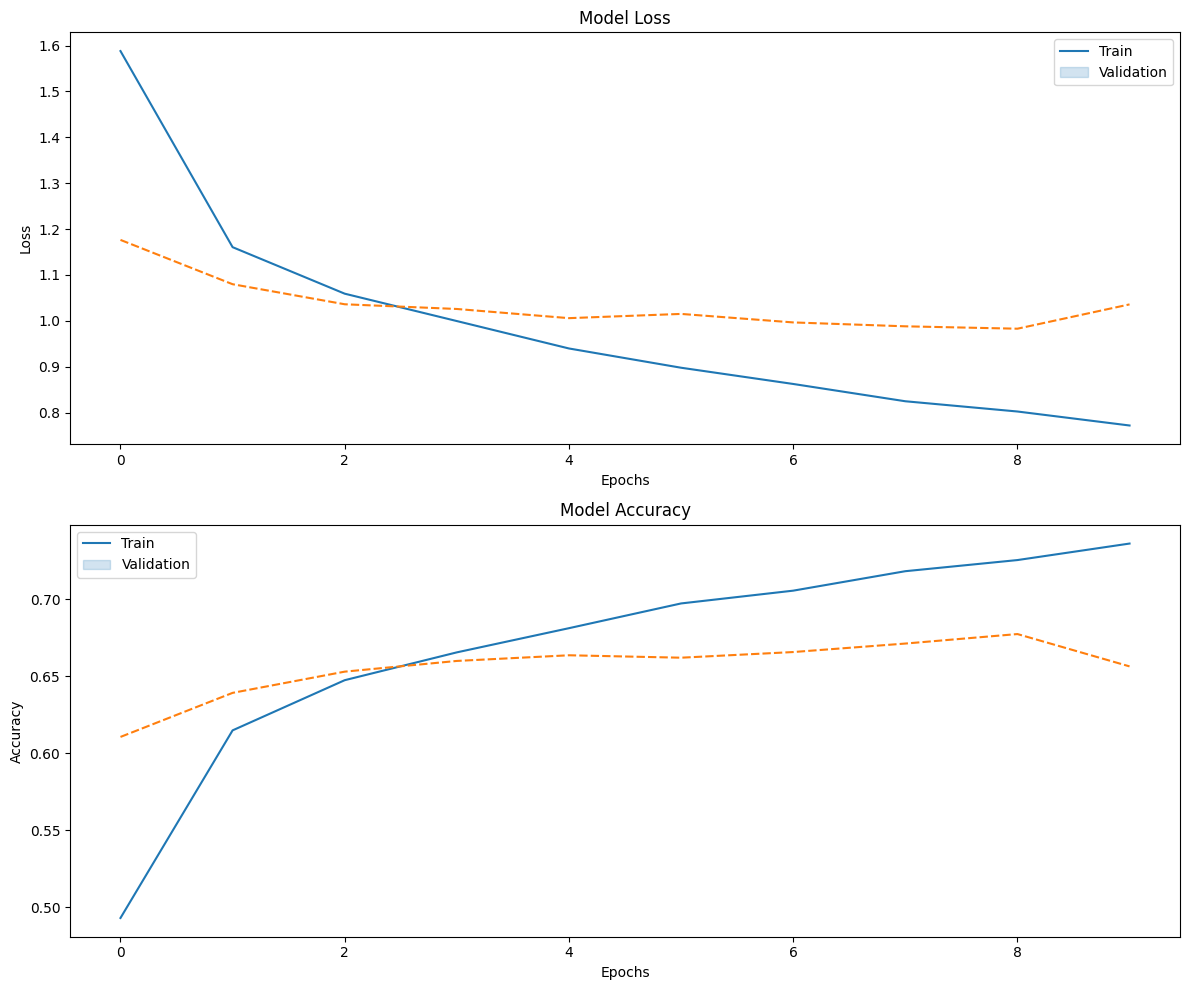

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,570 (9.89 MB)

 Trainable params: 333,074 (1.27 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

None
Epoch 1/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 122s 202ms/step - accuracy: 0.4345 - loss: 1.8286 - val_accuracy: 0.6289 - val_loss: 1.1147
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 108s 195ms/step - accuracy: 0.6439 - loss: 1.0804 - val_accuracy: 0.6459 - val_loss: 1.0576
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 109s 195ms/step - accuracy: 0.6845 - loss: 0.9554 - val_accuracy: 0.6459 - val_loss: 1.0530
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 109s 196ms/step - accuracy: 0.7047 - loss: 0.8770 - val_accuracy: 0.6674 - val_loss: 0.9818
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 107s 192ms/step - accuracy: 0.7190 - loss: 0.8211 - val_accuracy: 0.6616 - val_loss: 1.0190
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 110s 198ms/step - accuracy: 0.7386 - loss: 0.7634 - val_accuracy: 0.6631 - val_loss: 1.0088
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 105s 188ms/step - accuracy: 0.7563 - loss: 0.7144 - val_accuracy: 0.6694 - val_loss: 1.0158
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 106s 190ms/step - accuracy: 0.7

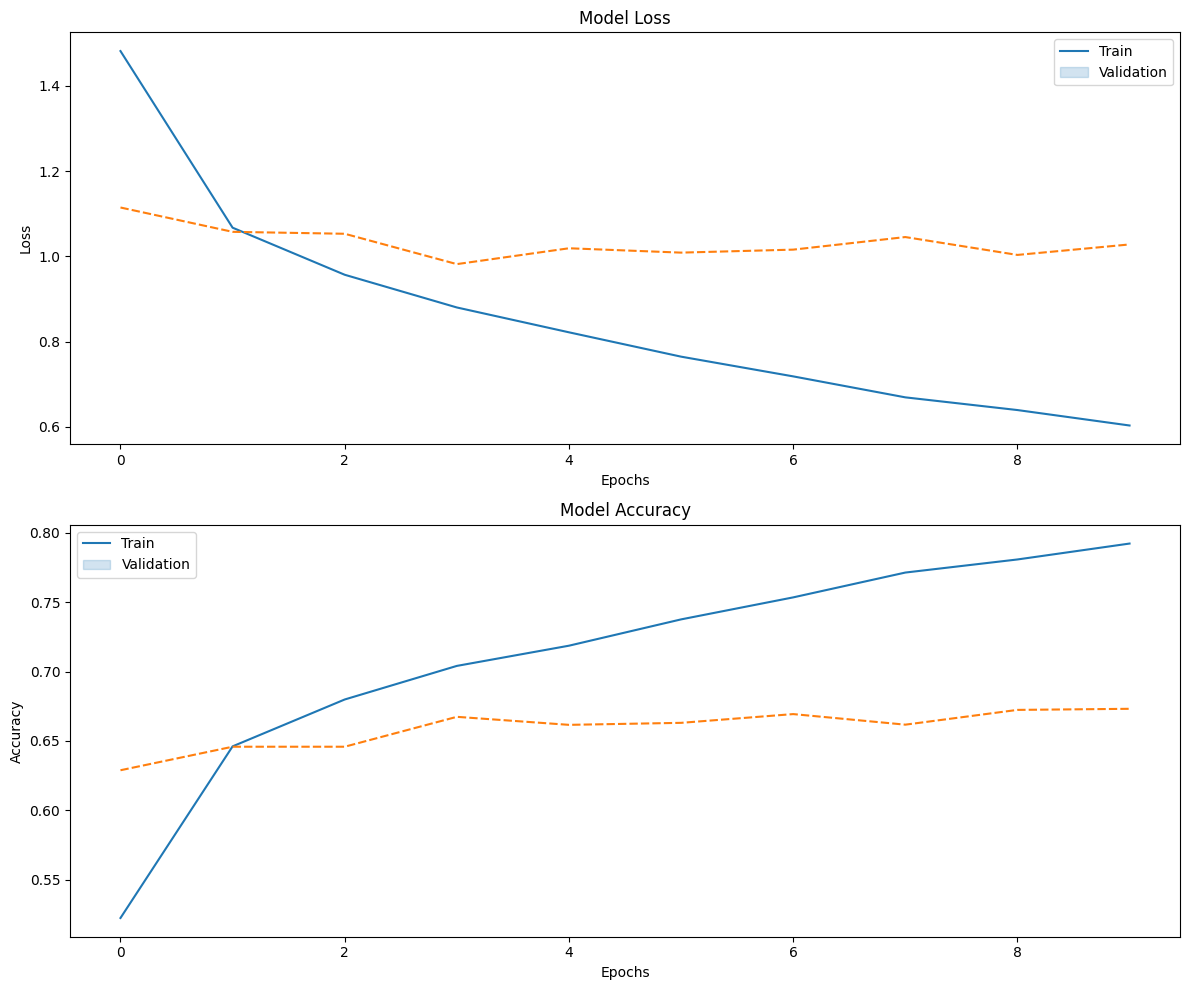

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,138 (11.16 MB)

 Trainable params: 666,130 (2.54 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

None
Epoch 1/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 116s 193ms/step - accuracy: 0.4688 - loss: 1.7060 - val_accuracy: 0.6309 - val_loss: 1.1018
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 104s 187ms/step - accuracy: 0.6695 - loss: 1.0030 - val_accuracy: 0.6482 - val_loss: 1.0611
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 101s 182ms/step - accuracy: 0.7051 - loss: 0.8777 - val_accuracy: 0.6602 - val_loss: 1.0130
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 104s 186ms/step - accuracy: 0.7362 - loss: 0.7894 - val_accuracy: 0.6671 - val_loss: 0.9892
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 104s 188ms/step - accuracy: 0.7582 - loss: 0.7172 - val_accuracy: 0.6636 - val_loss: 1.0276
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 105s 188ms/step - accuracy: 0.7808 - loss: 0.6423 - val_accuracy: 0.6712 - val_loss: 1.0278
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 101s 182ms/step - accuracy: 0.8006 - loss: 0.5903 - val_accuracy: 0.6690 - val_loss: 1.0436
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 102s 183ms/step - accuracy: 0.8

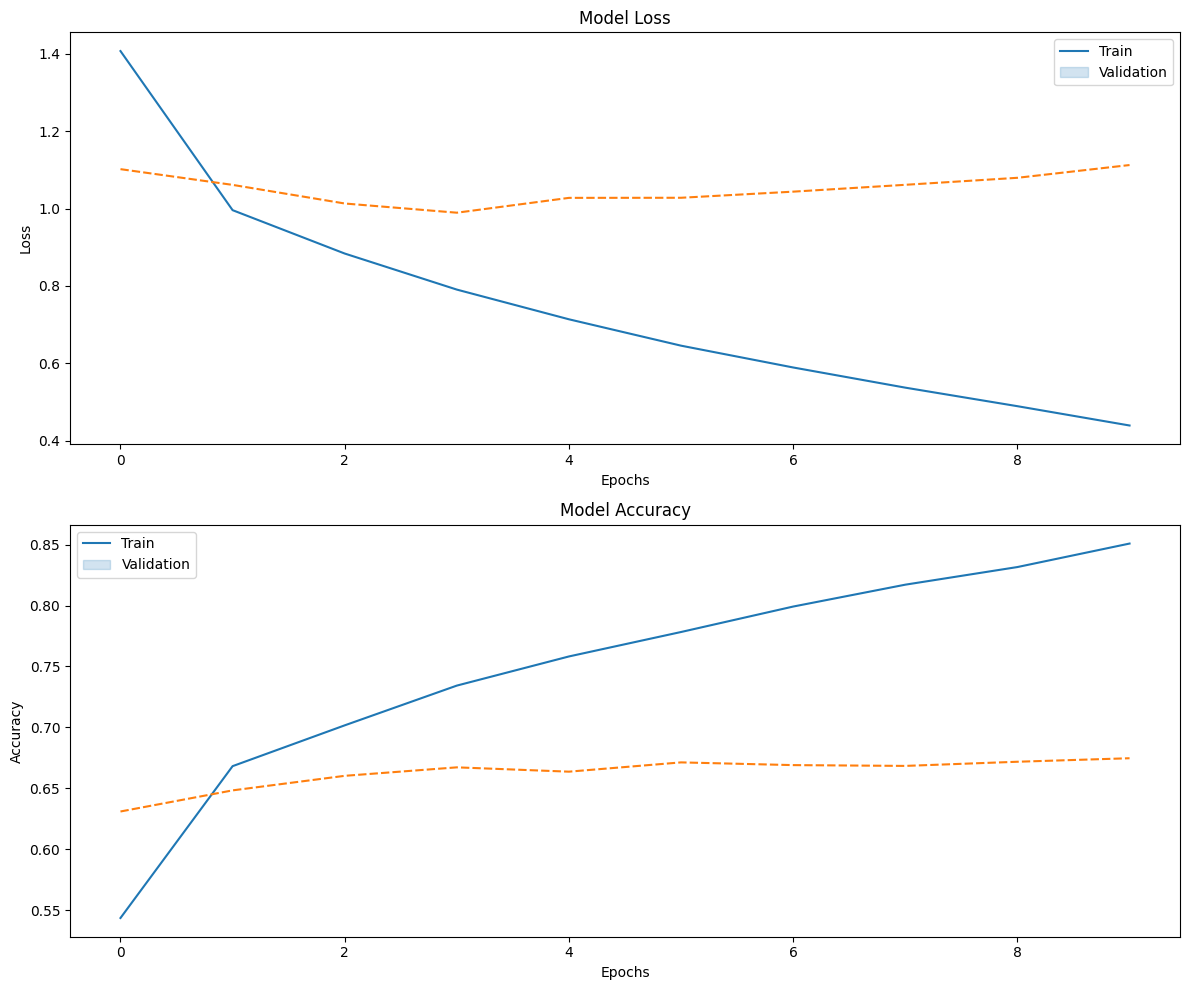

119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - accuracy: 0.6596 - loss: 1.1540
Test Loss: 1.152953028678894
Test Accuracy: 0.6589526534080505


In [13]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)


# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

### Confusion Matrix

  0%|          | 0/119 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step


  1%|          | 1/119 [00:31<1:01:01, 31.03s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  2%|▏         | 2/119 [00:31<25:12, 12.93s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  3%|▎         | 3/119 [00:31<13:46,  7.13s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  3%|▎         | 4/119 [00:31<08:27,  4.41s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  4%|▍         | 5/119 [00:31<05:30,  2.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  5%|▌         | 6/119 [00:32<03:44,  1.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  6%|▌         | 7/119 [00:32<02:38,  1.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  7%|▋         | 8/119 [00:32<01:55,  1.04s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  8%|▊         | 9/119 [00:32<01:26,  1.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  8%|▊         | 10/119 [00:33<01:06,  1.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  9%|▉         | 11/119 [00:33<00:53,  2.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 10%|█         | 12/119 [00:33<00:44,  2.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 11%|█         | 13/119 [00:33<00:37,  2.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 12%|█▏        | 14/119 [00:34<00:33,  3.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 13%|█▎        | 15/119 [00:34<00:30,  3.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 13%|█▎        | 16/119 [00:34<00:27,  3.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 14%|█▍        | 17/119 [00:34<00:27,  3.75it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 15%|█▌        | 18/119 [00:34<00:25,  3.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 16%|█▌        | 19/119 [00:35<00:24,  4.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 17%|█▋        | 20/119 [00:35<00:23,  4.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 18%|█▊        | 21/119 [00:35<00:22,  4.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 18%|█▊        | 22/119 [00:35<00:22,  4.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 19%|█▉        | 23/119 [00:36<00:22,  4.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 20%|██        | 24/119 [00:36<00:21,  4.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 21%|██        | 25/119 [00:36<00:21,  4.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 22%|██▏       | 26/119 [00:36<00:22,  4.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 23%|██▎       | 27/119 [00:37<00:22,  4.13it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 24%|██▎       | 28/119 [00:37<00:21,  4.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 24%|██▍       | 29/119 [00:37<00:20,  4.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 25%|██▌       | 30/119 [00:37<00:21,  4.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 26%|██▌       | 31/119 [00:37<00:21,  4.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 27%|██▋       | 32/119 [00:38<00:20,  4.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 28%|██▊       | 33/119 [00:38<00:23,  3.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 29%|██▊       | 34/119 [00:38<00:21,  3.88it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 29%|██▉       | 35/119 [00:39<00:21,  3.85it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 30%|███       | 36/119 [00:39<00:20,  4.03it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 31%|███       | 37/119 [00:39<00:19,  4.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 32%|███▏      | 38/119 [00:39<00:19,  4.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 33%|███▎      | 39/119 [00:40<00:20,  3.97it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 34%|███▎      | 40/119 [00:40<00:19,  4.06it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 34%|███▍      | 41/119 [00:40<00:19,  4.07it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 35%|███▌      | 42/119 [00:40<00:18,  4.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 36%|███▌      | 43/119 [00:40<00:17,  4.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 37%|███▋      | 44/119 [00:41<00:17,  4.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 38%|███▊      | 45/119 [00:41<00:17,  4.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 39%|███▊      | 46/119 [00:41<00:17,  4.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 39%|███▉      | 47/119 [00:41<00:16,  4.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 40%|████      | 48/119 [00:42<00:18,  3.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 41%|████      | 49/119 [00:42<00:17,  3.93it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 42%|████▏     | 50/119 [00:42<00:16,  4.11it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 43%|████▎     | 51/119 [00:42<00:16,  4.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 44%|████▎     | 52/119 [00:43<00:15,  4.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 45%|████▍     | 53/119 [00:43<00:15,  4.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 45%|████▌     | 54/119 [00:43<00:15,  4.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 46%|████▌     | 55/119 [00:43<00:15,  4.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 47%|████▋     | 56/119 [00:44<00:14,  4.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 48%|████▊     | 57/119 [00:44<00:14,  4.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 49%|████▊     | 58/119 [00:44<00:14,  4.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 50%|████▉     | 59/119 [00:44<00:13,  4.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 50%|█████     | 60/119 [00:45<00:13,  4.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 51%|█████▏    | 61/119 [00:45<00:13,  4.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 52%|█████▏    | 62/119 [00:45<00:13,  4.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 53%|█████▎    | 63/119 [00:45<00:13,  4.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 54%|█████▍    | 64/119 [00:45<00:12,  4.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 55%|█████▍    | 65/119 [00:46<00:12,  4.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 55%|█████▌    | 66/119 [00:46<00:12,  4.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 56%|█████▋    | 67/119 [00:46<00:11,  4.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 57%|█████▋    | 68/119 [00:46<00:11,  4.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 58%|█████▊    | 69/119 [00:47<00:11,  4.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 59%|█████▉    | 70/119 [00:47<00:11,  4.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 60%|█████▉    | 71/119 [00:47<00:10,  4.46it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 61%|██████    | 72/119 [00:47<00:10,  4.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 61%|██████▏   | 73/119 [00:47<00:10,  4.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 62%|██████▏   | 74/119 [00:48<00:10,  4.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 63%|██████▎   | 75/119 [00:48<00:09,  4.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 64%|██████▍   | 76/119 [00:48<00:09,  4.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 65%|██████▍   | 77/119 [00:48<00:09,  4.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 66%|██████▌   | 78/119 [00:49<00:09,  4.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 66%|██████▋   | 79/119 [00:49<00:09,  4.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 67%|██████▋   | 80/119 [00:49<00:09,  4.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 68%|██████▊   | 81/119 [00:49<00:08,  4.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 69%|██████▉   | 82/119 [00:50<00:08,  4.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 70%|██████▉   | 83/119 [00:50<00:08,  4.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 71%|███████   | 84/119 [00:50<00:07,  4.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 71%|███████▏  | 85/119 [00:50<00:07,  4.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 72%|███████▏  | 86/119 [00:50<00:07,  4.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 73%|███████▎  | 87/119 [00:51<00:07,  4.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 74%|███████▍  | 88/119 [00:51<00:07,  4.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 75%|███████▍  | 89/119 [00:51<00:07,  3.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 76%|███████▌  | 90/119 [00:51<00:07,  3.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 76%|███████▋  | 91/119 [00:52<00:06,  4.09it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 77%|███████▋  | 92/119 [00:52<00:06,  4.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 78%|███████▊  | 93/119 [00:52<00:06,  4.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 79%|███████▉  | 94/119 [00:52<00:05,  4.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 80%|███████▉  | 95/119 [00:53<00:05,  4.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 81%|████████  | 96/119 [00:53<00:05,  4.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 82%|████████▏ | 97/119 [00:53<00:04,  4.41it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 82%|████████▏ | 98/119 [00:53<00:04,  4.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 83%|████████▎ | 99/119 [00:54<00:04,  4.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 84%|████████▍ | 100/119 [00:54<00:04,  4.18it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 85%|████████▍ | 101/119 [00:54<00:04,  4.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 86%|████████▌ | 102/119 [00:54<00:03,  4.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 87%|████████▋ | 103/119 [00:54<00:03,  4.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 87%|████████▋ | 104/119 [00:55<00:03,  4.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 88%|████████▊ | 105/119 [00:55<00:03,  4.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 89%|████████▉ | 106/119 [00:55<00:02,  4.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 90%|████████▉ | 107/119 [00:55<00:02,  4.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 91%|█████████ | 108/119 [00:56<00:02,  4.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 92%|█████████▏| 109/119 [00:56<00:02,  4.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 92%|█████████▏| 110/119 [00:56<00:02,  4.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|█████████▎| 111/119 [00:56<00:01,  4.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 94%|█████████▍| 112/119 [00:57<00:01,  4.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 95%|█████████▍| 113/119 [00:57<00:01,  4.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 96%|█████████▌| 114/119 [00:57<00:01,  4.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 97%|█████████▋| 115/119 [00:57<00:00,  4.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 97%|█████████▋| 116/119 [00:57<00:00,  4.80it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 98%|█████████▊| 117/119 [00:58<00:00,  4.84it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 99%|█████████▉| 118/119 [00:58<00:00,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


100%|██████████| 119/119 [01:01<00:00,  1.95it/s]


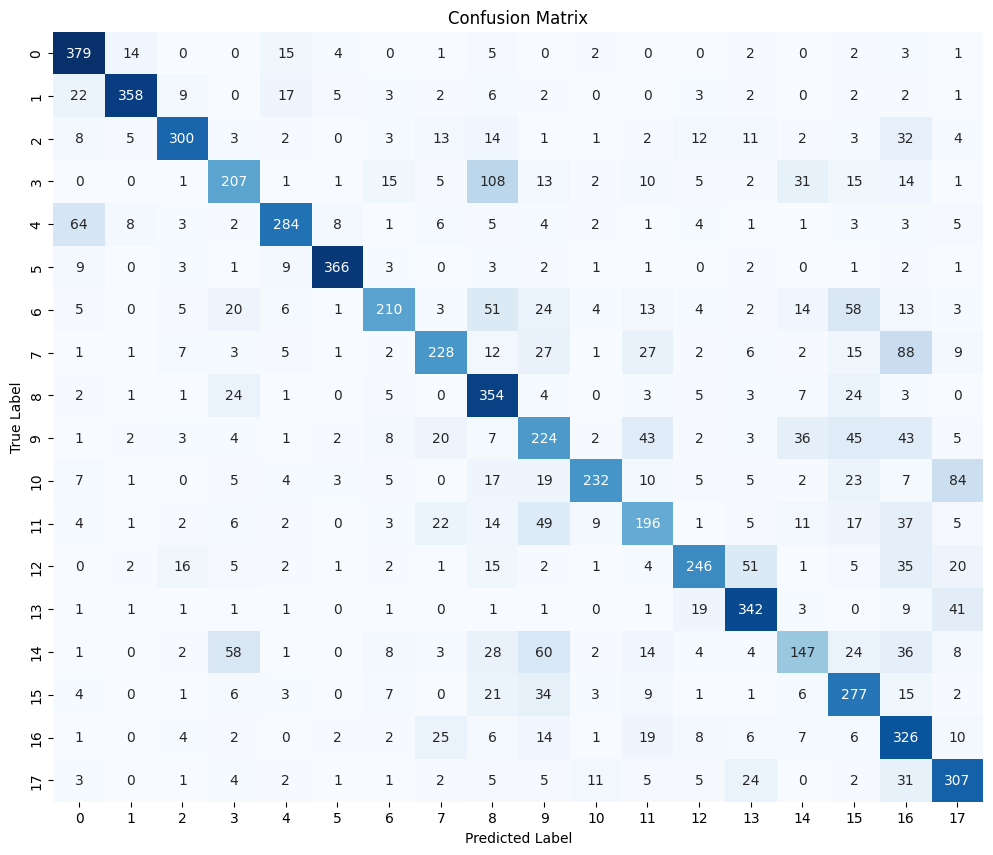

In [14]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)

## ConvNeXtBase Transfer Learning

Let's try to finetune `ConvNeXtBase` for our task.

`ConvNeXtBase` is trained on the `imagenet` dataset

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,700,498 (334.55 MB)

 Trainable params: 133,778 (522.57 KB)

 Non-trainable params: 87,566,720 (334.04 MB)

None
Epoch 1/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1146s 2s/step - accuracy: 0.3224 - loss: 2.1765 - val_accuracy: 0.5234 - val_loss: 1.4766
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1131s 2s/step - accuracy: 0.5504 - loss: 1.3765 - val_accuracy: 0.5442 - val_loss: 1.3547
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1113s 2s/step - accuracy: 0.5896 - loss: 1.2495 - val_accuracy: 0.5671 - val_loss: 1.3015
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1108s 2s/step - accuracy: 0.6109 - loss: 1.1871 - val_accuracy: 0.5662 - val_loss: 1.3472
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1107s 2s/step - accuracy: 0.6248 - loss: 1.1374 - val_accuracy: 0.5897 - val_loss: 1.2907
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1105s 2s/step - accuracy: 0.6387 - loss: 1.0966 - val_accuracy: 0.5756 - val_loss: 1.3433
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1112s 2s/step - accuracy: 0.6425 - loss: 1.0645 - val_accuracy: 0.5932 - val_loss: 1.2737
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - accuracy: 0.6593 - loss: 1.03

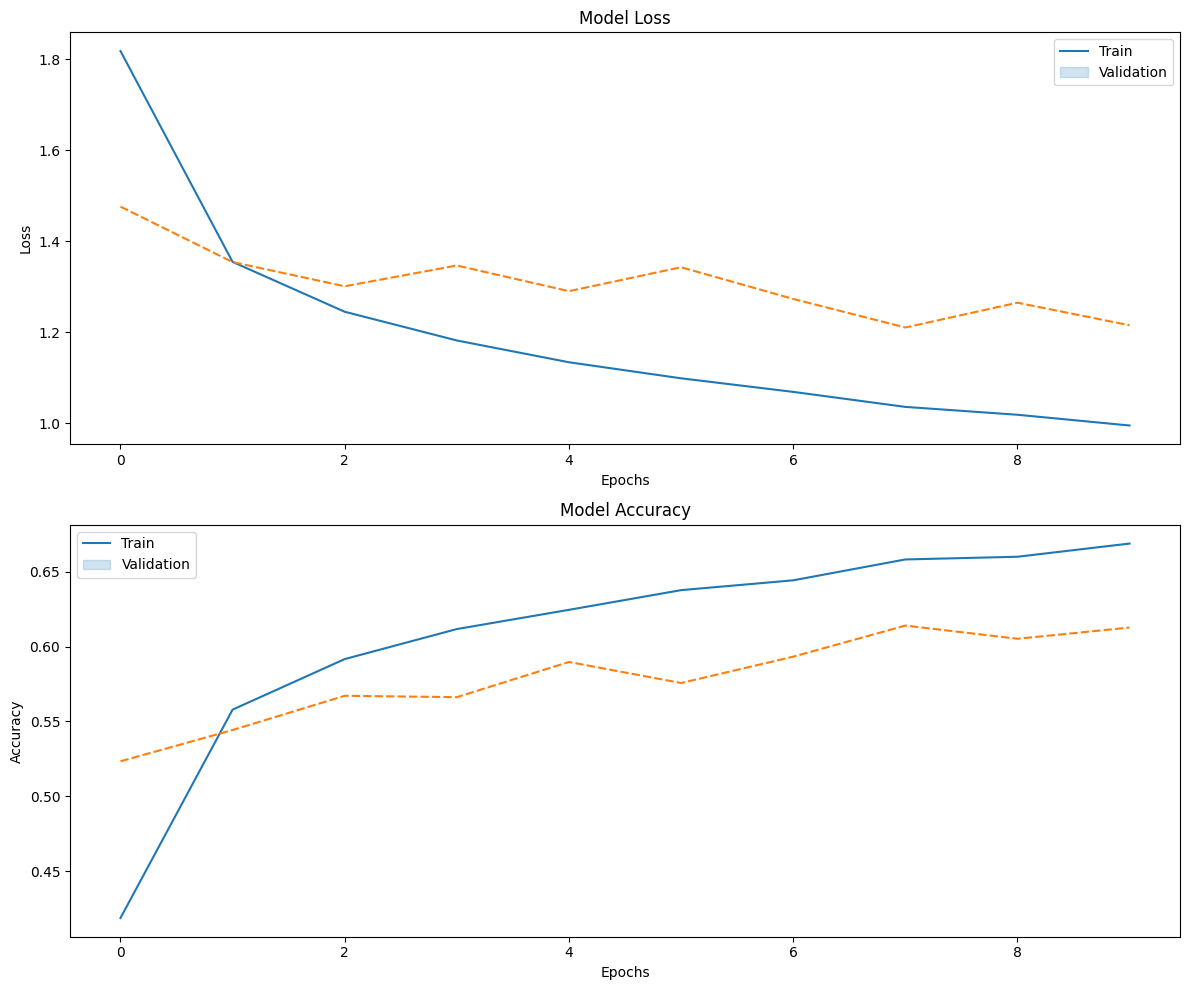

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,834,514 (335.06 MB)

 Trainable params: 267,538 (1.02 MB)

 Non-trainable params: 87,566,976 (334.04 MB)

None
Epoch 1/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1141s 2s/step - accuracy: 0.3563 - loss: 2.0944 - val_accuracy: 0.5135 - val_loss: 1.5034
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1109s 2s/step - accuracy: 0.5706 - loss: 1.3155 - val_accuracy: 0.5356 - val_loss: 1.3758
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - accuracy: 0.6164 - loss: 1.1780 - val_accuracy: 0.5645 - val_loss: 1.3206
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - accuracy: 0.6391 - loss: 1.1048 - val_accuracy: 0.5909 - val_loss: 1.3240
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1110s 2s/step - accuracy: 0.6543 - loss: 1.0505 - val_accuracy: 0.5916 - val_loss: 1.2946
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - accuracy: 0.6623 - loss: 1.0194 - val_accuracy: 0.5898 - val_loss: 1.2910
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1110s 2s/step - accuracy: 0.6787 - loss: 0.9740 - val_accuracy: 0.5664 - val_loss: 1.4597
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1110s 2s/step - accuracy: 0.6892 - loss: 0.93

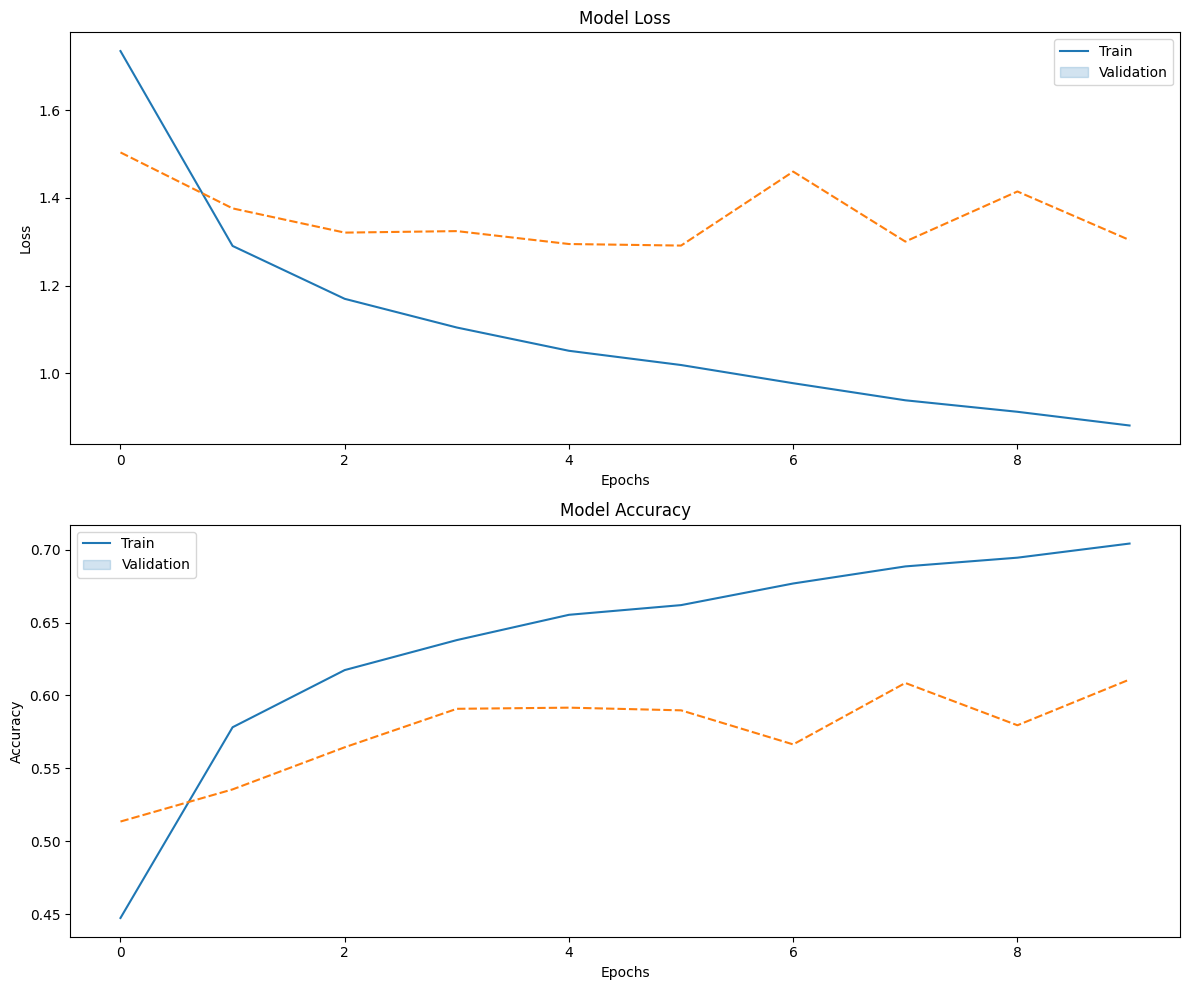

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,102,546 (336.08 MB)

 Trainable params: 535,058 (2.04 MB)

 Non-trainable params: 87,567,488 (334.04 MB)

None
Epoch 1/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1137s 2s/step - accuracy: 0.3857 - loss: 1.9994 - val_accuracy: 0.5511 - val_loss: 1.3895
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1106s 2s/step - accuracy: 0.5891 - loss: 1.2515 - val_accuracy: 0.5701 - val_loss: 1.3438
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1106s 2s/step - accuracy: 0.6272 - loss: 1.1293 - val_accuracy: 0.5546 - val_loss: 1.3963
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1106s 2s/step - accuracy: 0.6514 - loss: 1.0565 - val_accuracy: 0.5335 - val_loss: 1.5719
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1162s 2s/step - accuracy: 0.6681 - loss: 0.9988 - val_accuracy: 0.5901 - val_loss: 1.3263
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1107s 2s/step - accuracy: 0.6887 - loss: 0.9350 - val_accuracy: 0.5796 - val_loss: 1.3957
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1106s 2s/step - accuracy: 0.7015 - loss: 0.8981 - val_accuracy: 0.5772 - val_loss: 1.4019
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 1108s 2s/step - accuracy: 0.7135 - loss: 0.85

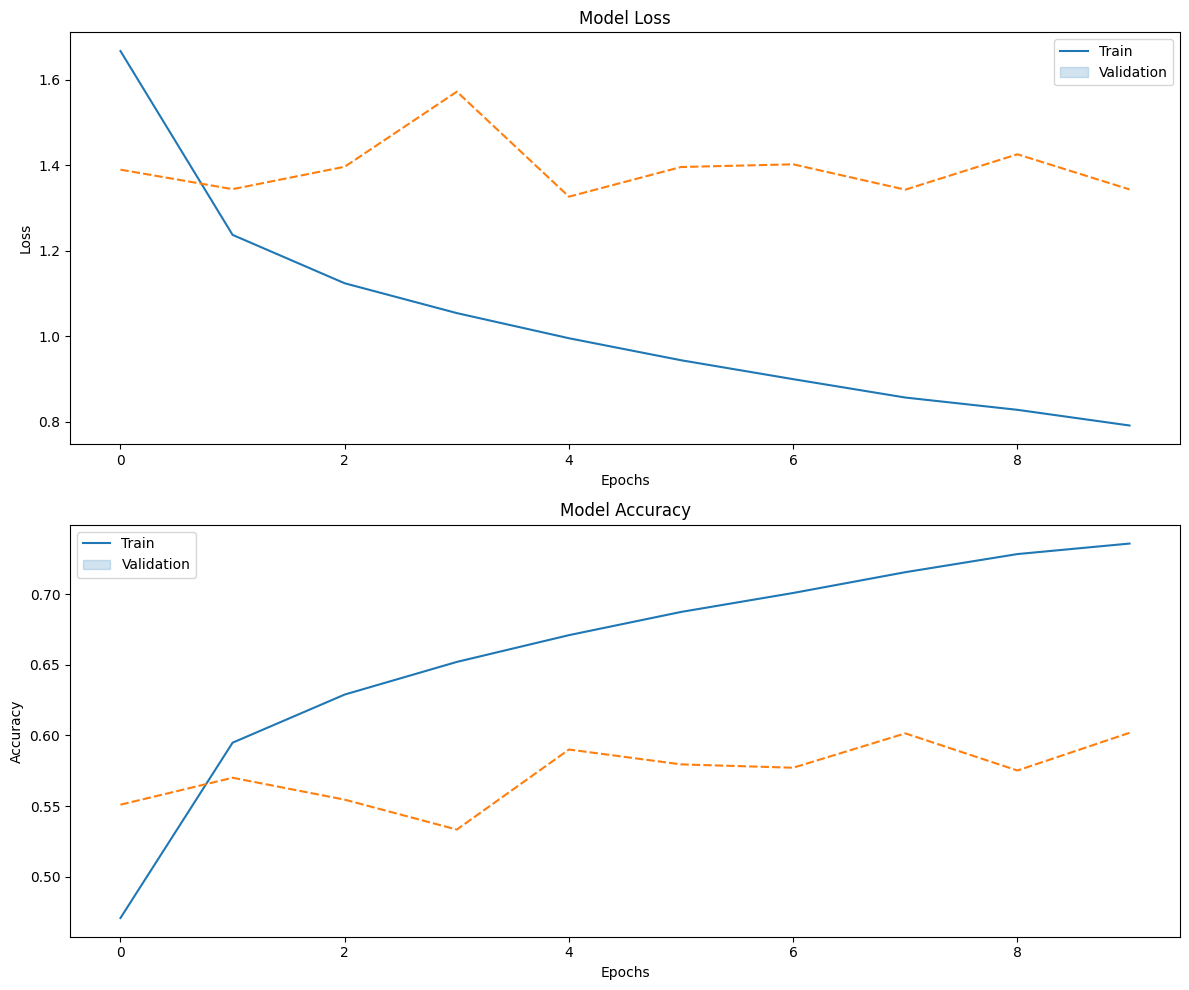

119/119 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.6168 - loss: 1.2141
Test Loss: 1.2235790491104126
Test Accuracy: 0.6150489449501038


In [26]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.ConvNeXtBase(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)

# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

### Confusion Matrix

  0%|          | 0/119 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 790ms/step


  1%|          | 1/119 [00:35<1:10:08, 35.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


  2%|▏         | 2/119 [00:37<30:32, 15.66s/it]  

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


  3%|▎         | 3/119 [00:39<17:56,  9.28s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


  3%|▎         | 4/119 [00:40<12:01,  6.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


  4%|▍         | 5/119 [00:42<08:45,  4.61s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


  5%|▌         | 6/119 [00:44<06:48,  3.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


  6%|▌         | 7/119 [00:45<05:35,  2.99s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


  7%|▋         | 8/119 [00:47<04:45,  2.57s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


  8%|▊         | 9/119 [00:49<04:11,  2.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


  8%|▊         | 10/119 [00:50<03:48,  2.09s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


  9%|▉         | 11/119 [00:52<03:31,  1.96s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 10%|█         | 12/119 [00:54<03:20,  1.87s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 11%|█         | 13/119 [00:55<03:11,  1.81s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 12%|█▏        | 14/119 [00:57<03:05,  1.77s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 13%|█▎        | 15/119 [00:59<03:01,  1.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 13%|█▎        | 16/119 [01:00<02:56,  1.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 14%|█▍        | 17/119 [01:02<02:53,  1.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 797ms/step


 15%|█▌        | 18/119 [01:04<02:50,  1.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 16%|█▌        | 19/119 [01:05<02:48,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 17%|█▋        | 20/119 [01:07<02:45,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step


 18%|█▊        | 21/119 [01:09<02:43,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 18%|█▊        | 22/119 [01:10<02:41,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 19%|█▉        | 23/119 [01:12<02:39,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 20%|██        | 24/119 [01:14<02:38,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


 21%|██        | 25/119 [01:15<02:36,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 22%|██▏       | 26/119 [01:17<02:34,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 23%|██▎       | 27/119 [01:19<02:33,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step


 24%|██▎       | 28/119 [01:20<02:31,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 24%|██▍       | 29/119 [01:22<02:29,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 25%|██▌       | 30/119 [01:24<02:28,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step


 26%|██▌       | 31/119 [01:25<02:26,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 27%|██▋       | 32/119 [01:27<02:24,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 28%|██▊       | 33/119 [01:29<02:23,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 802ms/step


 29%|██▊       | 34/119 [01:30<02:21,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


 29%|██▉       | 35/119 [01:32<02:20,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 30%|███       | 36/119 [01:34<02:18,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step


 31%|███       | 37/119 [01:35<02:16,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step


 32%|███▏      | 38/119 [01:37<02:15,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step


 33%|███▎      | 39/119 [01:39<02:14,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step


 34%|███▎      | 40/119 [01:40<02:12,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 797ms/step


 34%|███▍      | 41/119 [01:42<02:10,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 35%|███▌      | 42/119 [01:44<02:08,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 36%|███▌      | 43/119 [01:45<02:06,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step


 37%|███▋      | 44/119 [01:47<02:05,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 38%|███▊      | 45/119 [01:49<02:03,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 39%|███▊      | 46/119 [01:50<02:01,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step


 39%|███▉      | 47/119 [01:52<02:00,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 40%|████      | 48/119 [01:54<01:58,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 41%|████      | 49/119 [01:55<01:56,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 42%|████▏     | 50/119 [01:57<01:55,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 43%|████▎     | 51/119 [01:59<01:53,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 44%|████▎     | 52/119 [02:00<01:51,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 45%|████▍     | 53/119 [02:02<01:50,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


 45%|████▌     | 54/119 [02:04<01:48,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 46%|████▌     | 55/119 [02:05<01:46,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 47%|████▋     | 56/119 [02:07<01:44,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 48%|████▊     | 57/119 [02:09<01:43,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 49%|████▊     | 58/119 [02:10<01:41,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 50%|████▉     | 59/119 [02:12<01:40,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step


 50%|█████     | 60/119 [02:14<01:38,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step


 51%|█████▏    | 61/119 [02:15<01:36,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 52%|█████▏    | 62/119 [02:17<01:37,  1.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


 53%|█████▎    | 63/119 [02:19<01:34,  1.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 54%|█████▍    | 64/119 [02:20<01:32,  1.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 55%|█████▍    | 65/119 [02:22<01:30,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 55%|█████▌    | 66/119 [02:24<01:28,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 56%|█████▋    | 67/119 [02:25<01:26,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


 57%|█████▋    | 68/119 [02:27<01:25,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 58%|█████▊    | 69/119 [02:29<01:23,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 59%|█████▉    | 70/119 [02:30<01:21,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step


 60%|█████▉    | 71/119 [02:32<01:19,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 61%|██████    | 72/119 [02:34<01:18,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 61%|██████▏   | 73/119 [02:35<01:16,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 62%|██████▏   | 74/119 [02:37<01:15,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 63%|██████▎   | 75/119 [02:39<01:13,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 64%|██████▍   | 76/119 [02:40<01:11,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 65%|██████▍   | 77/119 [02:42<01:10,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 801ms/step


 66%|██████▌   | 78/119 [02:44<01:08,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 66%|██████▋   | 79/119 [02:45<01:06,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 67%|██████▋   | 80/119 [02:47<01:05,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 796ms/step


 68%|██████▊   | 81/119 [02:49<01:03,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 69%|██████▉   | 82/119 [02:50<01:01,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 70%|██████▉   | 83/119 [02:52<01:00,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 71%|███████   | 84/119 [02:54<00:58,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 71%|███████▏  | 85/119 [02:55<00:56,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 72%|███████▏  | 86/119 [02:57<00:55,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


 73%|███████▎  | 87/119 [02:59<00:53,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 74%|███████▍  | 88/119 [03:00<00:51,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 75%|███████▍  | 89/119 [03:02<00:50,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 76%|███████▌  | 90/119 [03:04<00:48,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 76%|███████▋  | 91/119 [03:05<00:46,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 77%|███████▋  | 92/119 [03:07<00:45,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 805ms/step


 78%|███████▊  | 93/119 [03:09<00:43,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 79%|███████▉  | 94/119 [03:10<00:41,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 80%|███████▉  | 95/119 [03:12<00:39,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step


 81%|████████  | 96/119 [03:14<00:38,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 82%|████████▏ | 97/119 [03:15<00:36,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 82%|████████▏ | 98/119 [03:17<00:34,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 83%|████████▎ | 99/119 [03:19<00:33,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 84%|████████▍ | 100/119 [03:20<00:31,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 85%|████████▍ | 101/119 [03:22<00:31,  1.75s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step


 86%|████████▌ | 102/119 [03:24<00:29,  1.72s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 87%|████████▋ | 103/119 [03:26<00:27,  1.71s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 87%|████████▋ | 104/119 [03:27<00:25,  1.70s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 88%|████████▊ | 105/119 [03:29<00:23,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 89%|████████▉ | 106/119 [03:31<00:21,  1.69s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step


 90%|████████▉ | 107/119 [03:32<00:20,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step


 91%|█████████ | 108/119 [03:34<00:18,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


 92%|█████████▏| 109/119 [03:36<00:16,  1.68s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 92%|█████████▏| 110/119 [03:37<00:15,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step


 93%|█████████▎| 111/119 [03:39<00:13,  1.67s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step


 94%|█████████▍| 112/119 [03:41<00:11,  1.66s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 95%|█████████▍| 113/119 [03:42<00:09,  1.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 797ms/step


 96%|█████████▌| 114/119 [03:44<00:08,  1.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 796ms/step


 97%|█████████▋| 115/119 [03:46<00:06,  1.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 804ms/step


 97%|█████████▋| 116/119 [03:47<00:04,  1.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


 98%|█████████▊| 117/119 [03:49<00:03,  1.65s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step


 99%|█████████▉| 118/119 [03:51<00:01,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


100%|██████████| 119/119 [03:56<00:00,  1.99s/it]


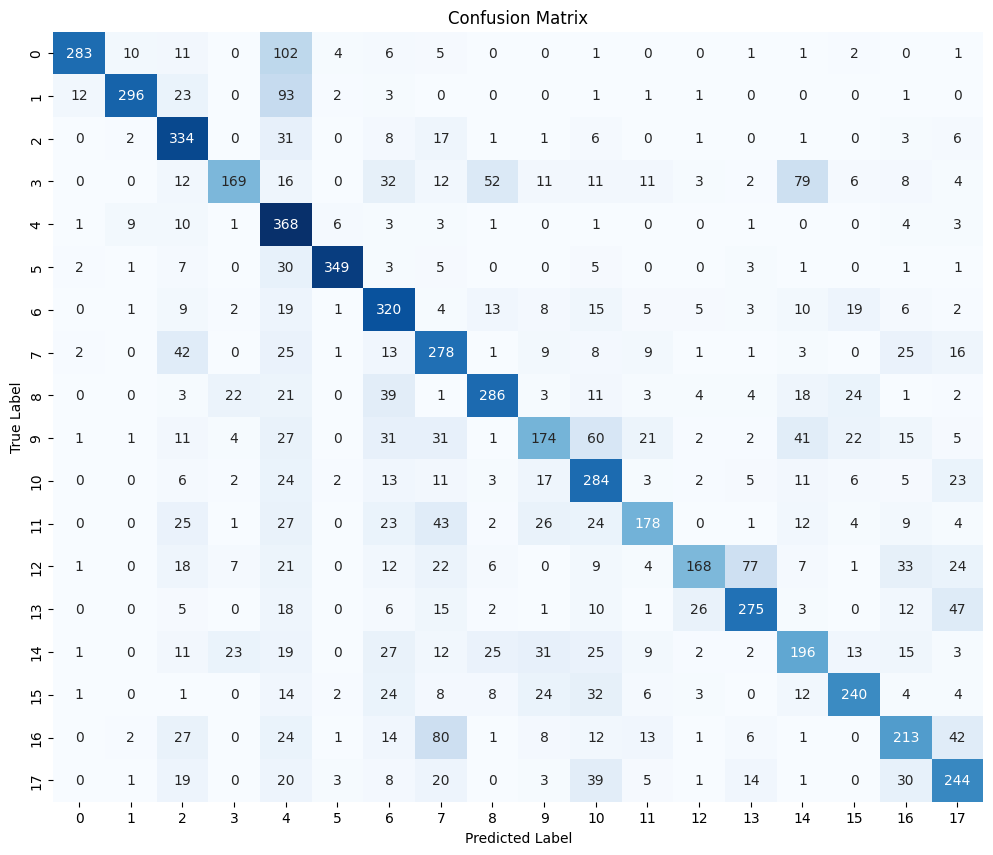

In [27]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)

## MobileNet FineTunning

Finally we will try to __finetune the entire MobileNet network__.

We expect this approach to perform better that the simple transfer learning, as we will be finetunning all the model parameters and not only the classification head.

Here, it's common to use a small learning rate.

__We will use the optimal model from the search above__, with a classification head of size `512`.

We first have to re-load the dataset with a smaller batch size, for example: `4`

In [28]:
dataset_path = "../../sign_datasets/hagrid-classification-512p-10-percent/"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=4,
    shuffle=True,
    seed=42,
)

train_size = int(len(dataset) * 0.7)

train_dataset = dataset.take(train_size)
temp_dataset = dataset.skip(train_size)
val_dataset = temp_dataset.take(int(0.5 * len(temp_dataset)))
test_dataset = temp_dataset.skip(int(0.5 * len(temp_dataset)))

def normalize_image(image, label):
    precomputed_mean = [0.5810514688491821, 0.5178735852241516, 0.48736947774887085]
    precomputed_std = [0.6329583525657654, 0.5746501684188843, 0.5465894937515259]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std

    return image, label

del temp_dataset

buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)

train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(f'Train batches: {len(train_dataset)}')
print(f'Validation batches: {len(val_dataset)}')
print(f'Test batches: {len(test_dataset)}')

Found 50698 files belonging to 18 classes.
Train batches: 8872
Validation batches: 1901
Test batches: 1902


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,138 (11.16 MB)

 Trainable params: 2,890,002 (11.02 MB)

 Non-trainable params: 35,136 (137.25 KB)

None
Epoch 1/10
8872/8872 ━━━━━━━━━━━━━━━━━━━━ 563s 58ms/step - accuracy: 0.5663 - loss: 1.4573 - val_accuracy: 0.9456 - val_loss: 0.2005
Epoch 2/10
8872/8872 ━━━━━━━━━━━━━━━━━━━━ 514s 58ms/step - accuracy: 0.9013 - loss: 0.3537 - val_accuracy: 0.9548 - val_loss: 0.1549
Epoch 3/10
8872/8872 ━━━━━━━━━━━━━━━━━━━━ 515s 58ms/step - accuracy: 0.9437 - loss: 0.2025 - val_accuracy: 0.9659 - val_loss: 0.1186
Epoch 4/10
8872/8872 ━━━━━━━━━━━━━━━━━━━━ 512s 58ms/step - accuracy: 0.9588 - loss: 0.1506 - val_accuracy: 0.9721 - val_loss: 0.1016
Epoch 5/10
8872/8872 ━━━━━━━━━━━━━━━━━━━━ 512s 58ms/step - accuracy: 0.9659 - loss: 0.1238 - val_accuracy: 0.9682 - val_loss: 0.1248
Epoch 6/10
8872/8872 ━━━━━━━━━━━━━━━━━━━━ 513s 58ms/step - accuracy: 0.9724 - loss: 0.0995 - val_accuracy: 0.9712 - val_loss: 0.1171
Epoch 7/10
8872/8872 ━━━━━━━━━━━━━━━━━━━━ 513s 58ms/step - accuracy: 0.9722 - loss: 0.0947 - val_accuracy: 0.9676 - val_loss: 0.1307
New best model found


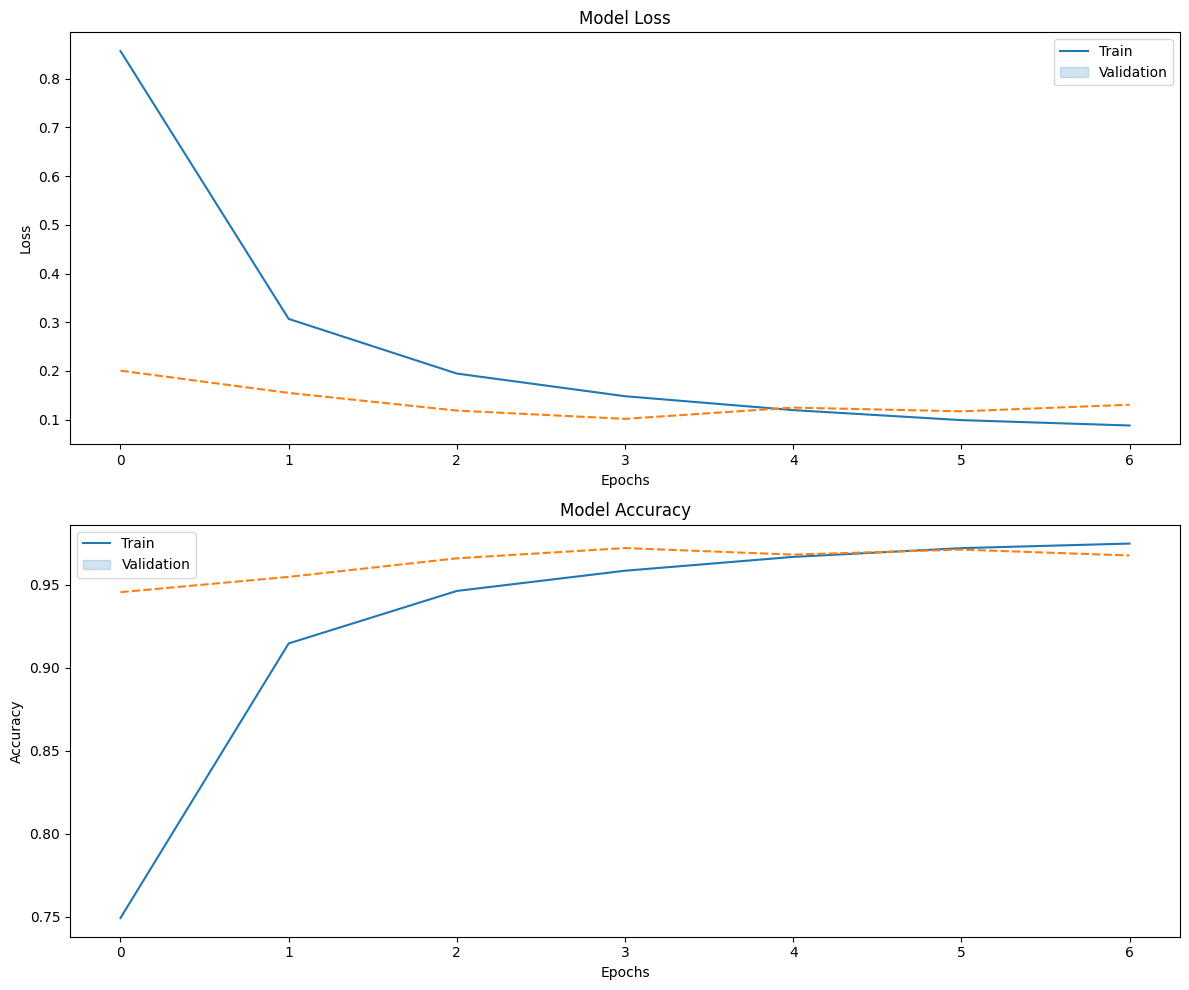

1902/1902 ━━━━━━━━━━━━━━━━━━━━ 62s 22ms/step - accuracy: 0.9683 - loss: 0.1169
Test Loss: 0.11290021240711212
Test Accuracy: 0.9691033363342285


In [29]:
HIDDEN_SIZE = 512

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # Metric to monitor
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)
# WE WANT to train the entire model
base_model.trainable = True


# Add custom layers on top of the base model
model = tf.keras.Sequential(
    [
        base_model,
        # This is added to reduce the number of parameters
        tf.keras.layers.GlobalAveragePooling2D(),
        # Add our custom hidden size
        tf.keras.layers.Dense(HIDDEN_SIZE, activation=None),
        # Use a batch normalization layer
        tf.keras.layers.BatchNormalization(),
        # Then the relu
        tf.keras.layers.Activation("relu"),
        # Dropout of 0.4
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

print(model.summary())

# Learning rate is set to 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping]
)

# make sure to keep the best model
if best_model is None or history.history["val_accuracy"][-1] > best_acc:
    print("New best model found")
    best_model = model
    best_acc = history.history["val_accuracy"][-1]

# plot two graphs, one for the train / val loss and one for the train / val accuracy
plot_history(history)


# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

### Confuion Matrix

100%|██████████| 1902/1902 [06:14<00:00,  5.07it/s]


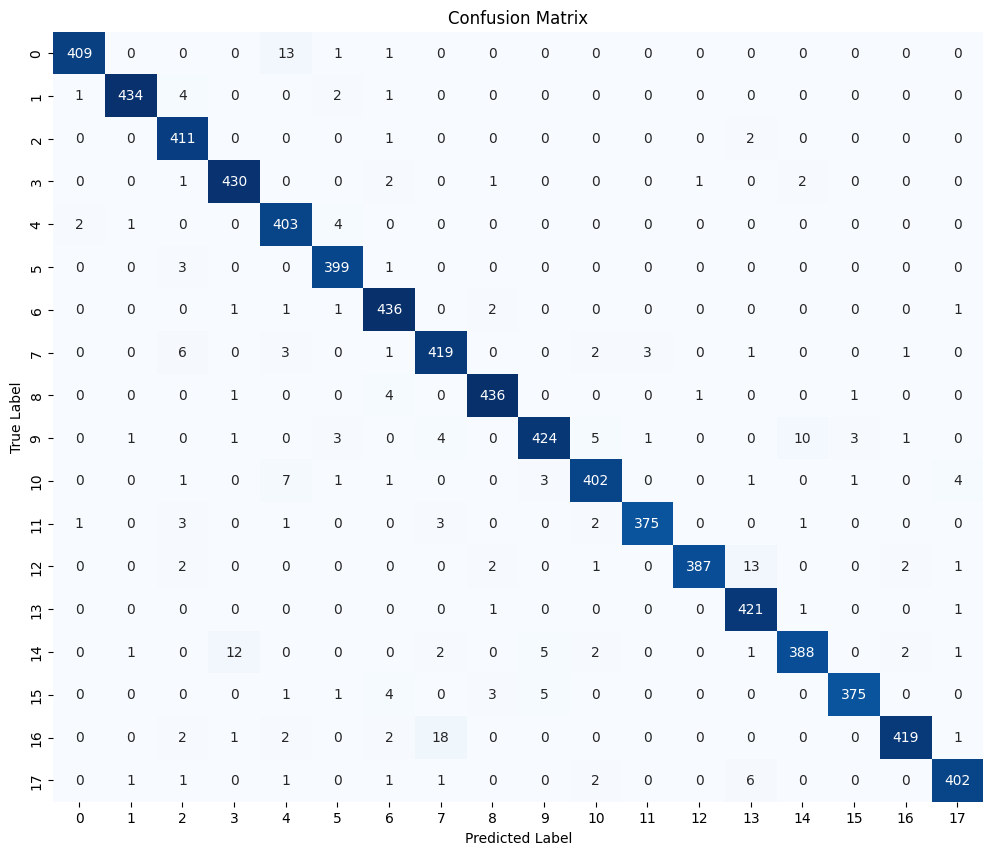

In [32]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch, verbose=0)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)